In [1]:
import sys
import os

# Add the project root directory to sys.path
project_root = r'C:\Users\Ian Bracken\Desktop\WebDev\nba-prediction-model'
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import pickle
from postgres.config import SessionLocal
from postgres.models import AdvancedPlayerStats, ClusteredPlayers





In [3]:
session = SessionLocal()

players = session.query(AdvancedPlayerStats).all()
# Convert ORM objects to a list of dictionaries
data = []
for player in players:
    player_dict = {column.name: getattr(player, column.name) for column in player.__table__.columns}
    data.append(player_dict)

df = pd.DataFrame(data)

df.set_index('PLAYER', inplace=True)


df = df[df['GP'] >= 10]
df = df[df['MIN'] >= 15]
# Perhaps a poor practice and should remove them in the scraping algorithm
df = df.drop(columns=['id', 'TEAM', 'W', 'L', 'GP', 'DREB', 'STL', 'BLK'])
# df = df.astype(float)
df.head()

,AGE,MIN,OFFRTG,DEFRTG,NETRTG,AST_PERCENT,AST_TO,AST_RATIO,OREB_PERCENT,DREB_PERCENT,...,FGM_UAST_PERCENT,DEF_RTG,DREB_PERCENT_TEAM,STL_PERCENT,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,DEFWS
PLAYER,,,,,,,,,,,,,,,,,,,,,
nicolas batum,36,17.7,106.5,101.9,4.6,10.5,2.95,29.1,3.7,11.4,...,8.9,101.9,11.4,18.9,23.7,6.4,4.7,5.1,15.9,0.104
deni avdija,24,28.2,110.3,117.3,-7.0,17.1,1.34,18.3,4.4,17.9,...,43.1,117.3,17.9,23.7,19.8,11.6,8.7,10.5,27.6,0.037
alperen sengun,22,31.3,114.7,106.5,8.2,25.1,2.05,19.9,9.9,21.5,...,53.3,106.5,21.5,23.2,27.5,9.7,8.5,8.7,31.0,0.138
amir coffey,27,25.5,109.0,106.5,2.5,6.7,1.71,11.5,2.1,7.7,...,17.1,106.5,7.7,12.7,3.9,10.5,6.3,8.5,25.4,0.113
jaden mcdaniels,24,30.7,110.3,110.6,-0.4,7.5,1.52,13.1,4.7,11.2,...,28.3,110.6,11.2,26.9,27.1,12.5,8.7,10.0,29.1,0.098


Removes the team column from the dataframe for now. It may be added back for future analysis but as a string it causes problems for the clustering algorithm. Also dropping players who have played less than 10 games because the sample size is so small.

In [4]:
dfPlayerCol = df.reset_index()
dfPlayerCol

,PLAYER,AGE,MIN,OFFRTG,DEFRTG,NETRTG,AST_PERCENT,AST_TO,AST_RATIO,OREB_PERCENT,...,FGM_UAST_PERCENT,DEF_RTG,DREB_PERCENT_TEAM,STL_PERCENT,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,DEFWS
0,nicolas batum,36,17.7,106.5,101.9,4.6,10.5,2.95,29.1,3.7,...,8.9,101.9,11.4,18.9,23.7,6.4,4.7,5.1,15.9,0.104
1,deni avdija,24,28.2,110.3,117.3,-7.0,17.1,1.34,18.3,4.4,...,43.1,117.3,17.9,23.7,19.8,11.6,8.7,10.5,27.6,0.037
2,alperen sengun,22,31.3,114.7,106.5,8.2,25.1,2.05,19.9,9.9,...,53.3,106.5,21.5,23.2,27.5,9.7,8.5,8.7,31.0,0.138
3,amir coffey,27,25.5,109.0,106.5,2.5,6.7,1.71,11.5,2.1,...,17.1,106.5,7.7,12.7,3.9,10.5,6.3,8.5,25.4,0.113
4,jaden mcdaniels,24,30.7,110.3,110.6,-0.4,7.5,1.52,13.1,4.7,...,28.3,110.6,11.2,26.9,27.1,12.5,8.7,10.0,29.1,0.098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,jordan clarkson,32,25.6,105.2,117.6,-12.4,26.2,1.53,18.1,2.4,...,60.5,117.6,10.1,20.7,14.9,13.5,10.0,10.2,27.8,0.031
306,herbert jones,26,32.4,111.8,112.5,-0.7,13.4,1.86,22.3,3.3,...,21.3,112.5,8.5,27.0,11.1,12.7,9.9,10.5,34.5,0.087
307,day'ron sharpe,23,17.4,108.2,111.9,-3.7,13.5,1.33,15.2,14.9,...,43.8,111.9,21.3,26.9,31.0,7.9,5.1,5.4,15.4,0.050
308,micah potter,26,17.3,106.6,108.9,-2.4,6.3,1.30,17.6,5.9,...,10.5,108.9,14.7,8.3,21.4,4.9,5.3,6.6,16.1,0.063


In [5]:
features = list(df.columns)
# Removes the column titles for data processing
x = df.loc[:, features].values
# Good practice to scale the data down based on variance
x = StandardScaler().fit_transform(x) 


Feature refers to the data that you are using in ML model to make predictions. Feature engineering is the process of finding the best features for the model. 

In [6]:
variance_list = []
for n_components in range(2,len(df.columns)):
    # Dimensionality Reduction
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(x)
    variance = sum(pca.explained_variance_ratio_)
    variance_list.append(variance)
    print(f"Variance with {n_components} components: {variance}")


Variance with 2 components: 0.4283452371662517
Variance with 3 components: 0.5327284822411836
Variance with 4 components: 0.6337071218109223
Variance with 5 components: 0.6879793788052346
Variance with 6 components: 0.7328470505326061
Variance with 7 components: 0.7679068262088298
Variance with 8 components: 0.798468024653536
Variance with 9 components: 0.8236118586020443
Variance with 10 components: 0.8475378996072134
Variance with 11 components: 0.8680287234557246
Variance with 12 components: 0.8877989283757688
Variance with 13 components: 0.9038459608034569
Variance with 14 components: 0.9186590926109943
Variance with 15 components: 0.9329448418240021
Variance with 16 components: 0.9448713992501798
Variance with 17 components: 0.9549499313393142
Variance with 18 components: 0.9638459367878451
Variance with 19 components: 0.9713936547404974
Variance with 20 components: 0.9780715093412874
Variance with 21 components: 0.9834422161647424
Variance with 22 components: 0.9875203362882204
V

This helps determine how much variance in the dataset is captured as the number of components increases. This will aid in choosing the ideal number of components for dimensionality reduction.

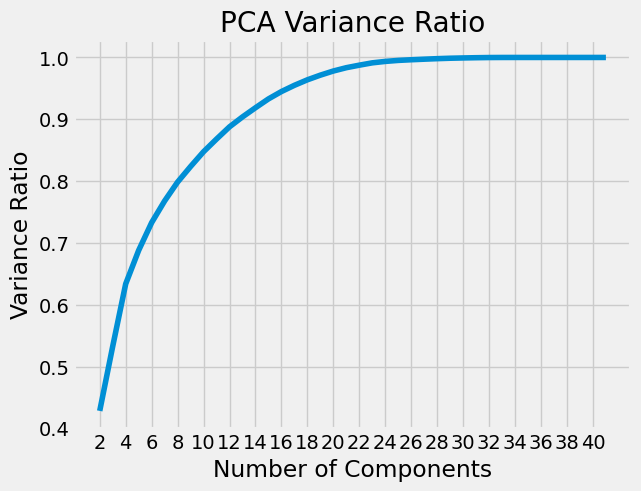

In [7]:
#Useful graph for visualization of ratio changes
plt.style.use('fivethirtyeight')
pca_fig, ax = plt.subplots()
ax.plot(range(2,len(df.columns)), variance_list)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('PCA Variance Ratio')
pca_fig.savefig('../images/PCA_Variance_Ratio.png')

In [8]:
from numpy import diff
diff_variance = diff(variance_list)
print(diff_variance)

[1.04383245e-01 1.00978640e-01 5.42722570e-02 4.48676717e-02
 3.50597757e-02 3.05611984e-02 2.51438339e-02 2.39260410e-02
 2.04908238e-02 1.97702049e-02 1.60470324e-02 1.48131318e-02
 1.42857492e-02 1.19265574e-02 1.00785321e-02 8.89600545e-03
 7.54771795e-03 6.67785460e-03 5.37070682e-03 4.07812012e-03
 3.76673936e-03 2.31119169e-03 1.63843981e-03 1.06143652e-03
 9.09813572e-04 8.43300352e-04 6.94822553e-04 4.62684199e-04
 3.81070872e-04 2.79916799e-04 1.10871068e-04 1.86840966e-05
 5.95508369e-07 8.66130957e-08 4.64386762e-09 3.54542840e-09
 2.51102672e-09 0.00000000e+00 0.00000000e+00]


This calculates the difference between consecutive elements in the variance_list array. Slope calculus, used to determine the "elbow point" in PCA which is where the rate of variance slows down

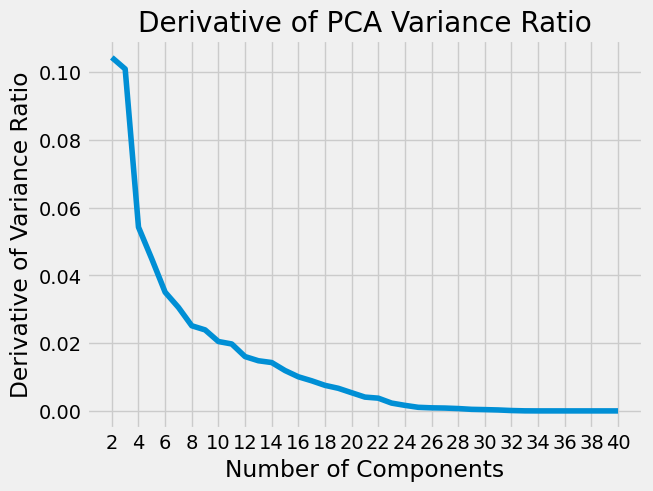

In [9]:
pca_deriv, ax = plt.subplots()
ax.plot(range(2, len(df.columns) - 1), diff_variance)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Derivative of Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('Derivative of PCA Variance Ratio')
pca_deriv.savefig('../images/PCA_Derivative.png')

Good data should have a high PCA Variance Ratio along with a low Derivative of the Variance Ratio. By using both criteria, you balance data representativeness (high variance ratio) and computational efficiency (low derivative).

In [10]:
n_comp = 16
pca = PCA(n_components=n_comp)

# Reducing the dimensions of the data
components = pca.fit_transform(x)

pca_df = pd.DataFrame(data = components, columns = [f'PC{i}' for i in range(1, n_comp + 1)])

pca_df['PLAYER'] = dfPlayerCol['PLAYER']
pca_df = pca_df[['PLAYER'] + [f'PC{i}' for i in range(1, n_comp + 1)]]
pca_df

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.21904355 0.20930169 0.10438325 0.10097864 0.05427226 0.04486767
 0.03505978 0.0305612  0.02514383 0.02392604 0.02049082 0.0197702
 0.01604703 0.01481313 0.01428575 0.01192656]
0.9448713992501798


In [11]:
x = np.column_stack([pca_df[f'PC{i}'] for i in range(1, n_comp)])

# We want a high silhouette score along with meaningful analysis
silhouette = []

for n_clusters in range(2, 32):
    kmeans = KMeans(n_clusters=n_clusters, random_state = 4)
    cluster_labels = kmeans.fit_predict(x)
    centers = kmeans.cluster_centers_
    score = silhouette_score(x, cluster_labels)
    silhouette.append(score)
    print(f"Silhouette Score with {n_clusters} clusters: {score}")

Silhouette Score with 2 clusters: 0.15033037690813772
Silhouette Score with 3 clusters: 0.1900814092811628
Silhouette Score with 4 clusters: 0.1419511573710753
Silhouette Score with 5 clusters: 0.12504055290395477
Silhouette Score with 6 clusters: 0.12528143637120093
Silhouette Score with 7 clusters: 0.12214935997862546
Silhouette Score with 8 clusters: 0.11765838462401634
Silhouette Score with 9 clusters: 0.11075493115003418
Silhouette Score with 10 clusters: 0.10619640303931002
Silhouette Score with 11 clusters: 0.09749167200696827
Silhouette Score with 12 clusters: 0.08884333172189114


Silhouette Score with 13 clusters: 0.08463080613385916
Silhouette Score with 14 clusters: 0.0859477613867323
Silhouette Score with 15 clusters: 0.07853644309640942
Silhouette Score with 16 clusters: 0.083880324104904
Silhouette Score with 17 clusters: 0.07715128660950307
Silhouette Score with 18 clusters: 0.08041924571770506
Silhouette Score with 19 clusters: 0.07886636371723467
Silhouette Score with 20 clusters: 0.07170306403181474
Silhouette Score with 21 clusters: 0.08374488839643139
Silhouette Score with 22 clusters: 0.07282642766280609
Silhouette Score with 23 clusters: 0.07263125739773067
Silhouette Score with 24 clusters: 0.07292874974538108
Silhouette Score with 25 clusters: 0.07101640933196879
Silhouette Score with 26 clusters: 0.07035100416930826
Silhouette Score with 27 clusters: 0.067977852911446
Silhouette Score with 28 clusters: 0.0680269958523364
Silhouette Score with 29 clusters: 0.06973514552663486
Silhouette Score with 30 clusters: 0.06660326056981389
Silhouette Score

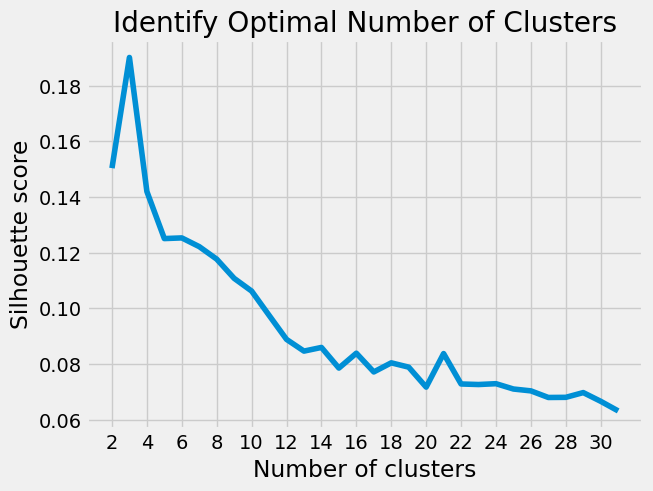

In [12]:
plt.style.use('fivethirtyeight')
silhouette_fig, ax = plt.subplots()
ax.plot(range(2,2 + len(silhouette)), silhouette)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_xticks(np.arange(2, 2+len(silhouette), 2))
ax.set_title('Identify Optimal Number of Clusters')
silhouette_fig.savefig('../images/Optimal_Clusters.png')

In [13]:
silhouette_diff = []

for i in range(1, len(silhouette)):
    improvement = 1 - ((1-silhouette[i]) / (1 - silhouette[i - 1]))
    silhouette_diff.append(improvement)
    print(f"for n_cluseter = {i + 2}, improvement = {improvement}") 

for n_cluseter = 3, improvement = 0.04678410442446457
for n_cluseter = 4, improvement = -0.059426036717307396
for n_cluseter = 5, improvement = -0.0197082073035717
for n_cluseter = 6, improvement = 0.0002753081506184918
for n_cluseter = 7, improvement = -0.003580667568757079
for n_cluseter = 8, improvement = -0.00511587638017752
for n_cluseter = 9, improvement = -0.007824014365502174
for n_cluseter = 10, improvement = -0.00512629000756748
for n_cluseter = 11, improvement = -0.00973897516405331
for n_cluseter = 12, improvement = -0.009582560090397152
for n_cluseter = 13, improvement = -0.004623272522378263
for n_cluseter = 14, improvement = 0.0014387148504646508
for n_cluseter = 15, improvement = -0.008108199922541415
for n_cluseter = 16, improvement = 0.005799340590800672
for n_cluseter = 17, improvement = -0.007345151154870999
for n_cluseter = 18, improvement = 0.0035411645059304497
for n_cluseter = 19, improvement = -0.0016886847546981887
for n_cluseter = 20, improvement = -0.0077766

C:\conda_tmp\ipykernel_25804\1289475222.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


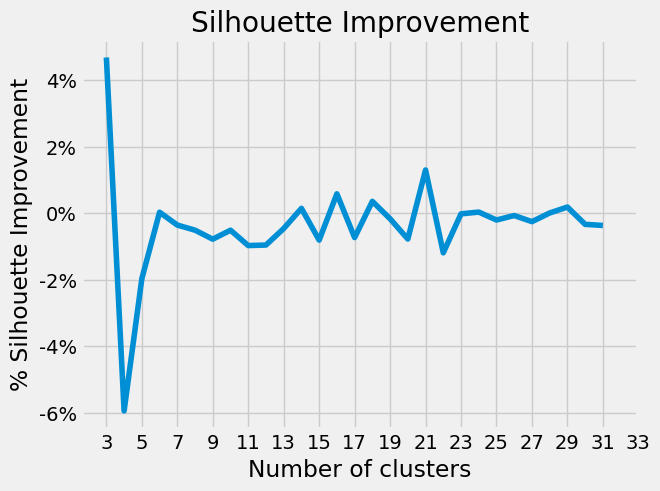

In [14]:
plt.style.use('fivethirtyeight')
silhouette_improvement_fig, ax = plt.subplots()
ax.plot(range(3, 2 + len(silhouette)), silhouette_diff)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('% Silhouette Improvement')
ax.set_xticks(np.arange(3, 4 + len(silhouette), 2))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_title('Silhouette Improvement')
silhouette_fig.savefig('../images/Silhouette_Improvement.png')

In [15]:
kmeans = KMeans(n_clusters = 15, random_state = 4)

kmeans.fit(x)

y_kmeans = kmeans.predict(x)
with open("../models/clusterMode.sav", 'wb') as f:
    pickle.dump(kmeans, f)

In [16]:
df_cluster = pd.DataFrame()

df_cluster['Player'] = dfPlayerCol['PLAYER']
df_cluster['Cluster'] = y_kmeans
df_cluster.head()

,Player,Cluster
0,nicolas batum,0
1,deni avdija,12
2,alperen sengun,3
3,amir coffey,4
4,jaden mcdaniels,4


In [17]:
df_cluster.columns = df_cluster.columns.str.upper()
for _, row in df_cluster.iterrows():
    existing_player = session.query(ClusteredPlayers).filter_by(PLAYER=row['PLAYER']).first()
    if existing_player:
        # Update the cluster value if the player exists
        existing_player.CLUSTER = row['CLUSTER']
    else:
        # Convert the row to a dictionary and pass it to the model
        clustered_player = ClusteredPlayers(
            PLAYER=row['PLAYER'],
            CLUSTER=row['CLUSTER']
        )
        session.add(clustered_player)
session.commit()

session.close()